In [9]:
import numpy as np
import torch
from torch import nn
import torch
from basic_CNN import basic_CNN as CNN
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# Setting

In [1]:
class config:
    dataroot = 'data'
    workers = 1
    imageSize = 32
    nc = 1 # input image channels
    ngpu = 1
    state_cnn = 'saved_models/models/fmnist/cnn.pth'
    batch_size = 1
    train_batchsize = 1
    num_samples=20
opt = config

np.random.seed(1234)
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

# DataLoader

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

cnn = CNN(opt.imageSize, opt.nc).to(device)
state_cnn = torch.load(opt.state_cnn, map_location = device)
cnn.load_state_dict(state_cnn)

cnn.eval()

basic_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=625, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)

In [3]:
dataset_fmnist = dset.FashionMNIST(root=opt.dataroot, train=False, download=True, transform=transforms.Compose([
                                transforms.Resize((opt.imageSize)),
                                transforms.ToTensor(),
                            ]))
test_loader_fmnist = torch.utils.data.DataLoader(dataset_fmnist, batch_size=opt.batch_size,
                                            shuffle=False, num_workers=int(opt.workers))
    
dataset_mnist = dset.MNIST(root=opt.dataroot, train=False, download=True, transform=transforms.Compose([
                                transforms.Resize((opt.imageSize,opt.imageSize)),
                                transforms.ToTensor(),
                            ]))

test_loader_mnist = torch.utils.data.DataLoader(dataset_mnist, batch_size=opt.batch_size,
                                            shuffle=False, num_workers=int(opt.workers))

In [4]:
acc = 0
for i, (x,y) in enumerate(test_loader_fmnist):
    pred = cnn(x.float().cuda())
    if torch.argmax(pred).detach().cpu() == y:
        acc += 1
    if i==10000:
        break
acc/10000

0.9285

# Basic Gradient Method

In [4]:
optimizer = optim.SGD(cnn.parameters(), lr=0, momentum=0)
loss_fn = nn.CrossEntropyLoss(reduction='mean')

In [5]:
fmnist_Gradients = []
for i, (x, y) in enumerate(test_loader_fmnist):
    x = x.to(device)
    y = y.to(device)
    y_pred = cnn(x)
    optimizer.zero_grad()
    loss = loss_fn(y_pred, y)
    loss.backward()
    gradient_val = sum([torch.norm(p.grad)**2 for p in cnn.parameters()])
    fmnist_Gradients.append(gradient_val.detach().cpu())
    if i%3000==2999:
        break

In [6]:
mnist_Gradients = []
for i, (x, y) in enumerate(test_loader_mnist):
    x = x.to(device)
    y = y.to(device)
    y_pred = cnn(x)
    optimizer.zero_grad()
    loss = loss_fn(y_pred, y)
    loss.backward()
    gradient_val = sum([torch.norm(p.grad)**2 for p in cnn.parameters()])
    mnist_Gradients.append(gradient_val.detach().cpu())
    if i%3000==2999:
        break

(array([400.,  28.,  17.,  16.,  20.,   9.,   8.,  19.,  20.,  17.,  15.,
         22.,  26.,  31.,  41.,  55.,  54.,  62.,  57.,  67.,  61.,  52.,
         55.,  58.,  65.,  56.,  58.,  64.,  67.,  81.,  49.,  64.,  57.,
         55.,  62.,  71.,  68.,  54.,  54.,  63.,  48.,  57.,  50.,  50.,
         52.,  50.,  33.,  39.,  35.,  43.,  28.,  28.,  27.,  28.,  26.,
         13.,  23.,  19.,  20.,   7.,  12.,  16.,  12.,   6.,  14.,  14.,
          3.,   6.,   6.,   3.,   3.,   5.,   6.,   5.,   1.,   3.,   1.,
          1.,   2.,   2.,   3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([2.3388212e-25, 1.3520838e+01, 2.7041676e+01, 4.0562511e+01,
        5.4083351e+01, 6.7604187e+01, 8.1125023e+01, 9.4645859e+01,
        1.0816670e+02, 1.2168754e+02, 1.3520837e+02, 1.4872922e+02,
        1.6225005e+02, 1.7577089e+02, 1.8929172e+02, 2.0281256e+02,
        2.1633340e+02, 2.2985423e+02, 2.433750

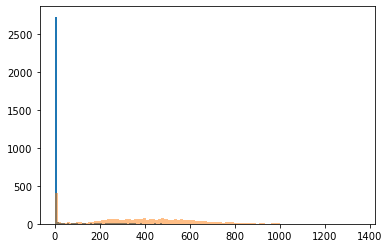

In [7]:

fmnist_Gradients = torch.tensor(fmnist_Gradients)/100
plt.hist(fmnist_Gradients, bins=100)

mnist_Gradients = torch.tensor(mnist_Gradients)/100
plt.hist(mnist_Gradients, bins=100, alpha=0.5)

AUC for Gradient Norm is:  0.9557111111111112


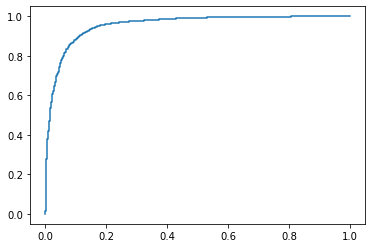

In [8]:
from sklearn import metrics

combined = np.concatenate((fmnist_Gradients, mnist_Gradients))
label_1 = np.ones(len(fmnist_Gradients))
label_2 = np.zeros(len(mnist_Gradients))
label = np.concatenate((label_1, label_2))

fpr, tpr, thresholds = metrics.roc_curve(label, combined, pos_label=0)

#plot_roc_curve(fpr, tpr)

rocauc = metrics.auc(fpr, tpr)
print('AUC for Gradient Norm is: ', rocauc)
plt.plot(fpr, tpr)

# Naive Fisher Information

In [5]:
dicts = [cnn.fc2]

In [6]:
dataset_fmnist_train = dset.FashionMNIST(root=opt.dataroot, train=True, download=True, transform=transforms.Compose([
                                transforms.Resize((opt.imageSize)),
                                transforms.ToTensor(),
                            ]))
dataloader_fmnist = torch.utils.data.DataLoader(dataset_fmnist_train, batch_size=opt.train_batchsize,
                                                shuffle=True, num_workers=int(opt.workers))

In [7]:
optimizer = optim.SGD(cnn.parameters(), lr=0,momentum=0)
loss_fn = nn.CrossEntropyLoss(reduction = 'mean')

for i, (x, y) in enumerate(dataloader_fmnist):
    optimizer.zero_grad()
    x = x.to(device)
    y = y.to(device)
    y_pred = cnn(x)
    optimizer.zero_grad()
    loss = loss_fn(y_pred, y)
    loss.backward()
    grads = []
    for x in dicts:
        for param in x.parameters():
            grads.append(param.grad.view(-1)**2) 
    grads = torch.cat(grads)
    if i!=0:
        Grads = (i*Grads + grads)/(i+1)
    else:
        Grads = grads

Grads = torch.sqrt(Grads)
Grads = 1000*Grads+0.0001

(array([4.141e+03, 1.510e+02, 1.560e+02, 1.520e+02, 1.480e+02, 1.490e+02,
        1.140e+02, 1.080e+02, 1.370e+02, 9.000e+01, 9.400e+01, 9.700e+01,
        8.400e+01, 6.600e+01, 5.800e+01, 4.600e+01, 4.100e+01, 3.400e+01,
        4.500e+01, 3.700e+01, 2.800e+01, 2.000e+01, 2.200e+01, 2.100e+01,
        1.700e+01, 1.200e+01, 1.000e+01, 1.900e+01, 1.200e+01, 1.200e+01,
        7.000e+00, 1.000e+01, 1.200e+01, 9.000e+00, 3.000e+00, 1.200e+01,
        7.000e+00, 8.000e+00, 4.000e+00, 5.000e+00, 2.000e+00, 5.000e+00,
        2.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
        1.000e+00, 2.000e+00, 5.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        4.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+0

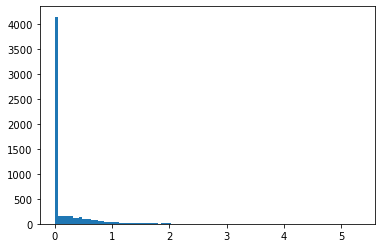

In [10]:
plt.hist(np.where(Grads.detach().cpu()>2000, 2000, Grads.detach().cpu()), bins=100)

In [34]:
temp=10
fmnist_Gradients = []
for i, (x, _) in enumerate(test_loader_fmnist):
    x = x.to(device)
    y_pred = cnn(x)
    y = torch.argmax(y_pred, dim=1)
    optimizer.zero_grad()
    loss = loss_fn(y_pred/temp, y)
    loss.backward()
    grads = []
    for x in dicts:
        for param in x.parameters():
            grads.append(param.grad.view(-1)**2) 
    grads = torch.cat(grads)
    gradient_val = torch.norm(grads/Grads)
    fmnist_Gradients.append(gradient_val.detach().cpu())
    if i%3000==2999:
        break

In [35]:
mnist_Gradients = []
for i, (x, _) in enumerate(test_loader_mnist):
    x = x.to(device)
    y_pred = cnn(x)
    y = torch.argmax(y_pred, dim=1)
    optimizer.zero_grad()
    loss = loss_fn(y_pred/temp, y)
    loss.backward()
    grads = []
    for x in dicts:
        for param in x.parameters():
            grads.append(param.grad.view(-1)**2) 
    grads = torch.cat(grads)
    gradient_val = torch.norm(grads/Grads)
    mnist_Gradients.append(gradient_val.detach().cpu())
    if i%3000==2999:
        break

(0, 5)

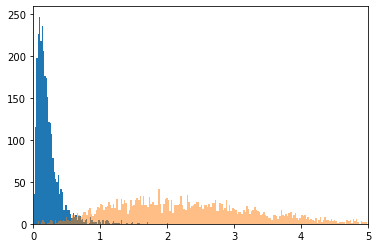

In [36]:
import matplotlib.pyplot as plt
fmnist_Gradients = torch.tensor(fmnist_Gradients)
plt.hist(fmnist_Gradients, bins=100)

mnist_Gradients = torch.tensor(mnist_Gradients)
plt.hist(mnist_Gradients, bins=400, alpha=0.5)
plt.xlim(0,5)

AUC for Gradient Norm is:  0.9924385555555555


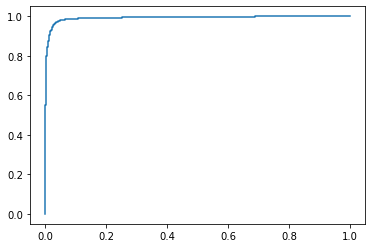

In [37]:
from sklearn import metrics

combined = np.concatenate((fmnist_Gradients, mnist_Gradients))
label_1 = np.ones(len(fmnist_Gradients))
label_2 = np.zeros(len(mnist_Gradients))
label = np.concatenate((label_1, label_2))

fpr, tpr, thresholds = metrics.roc_curve(label, combined, pos_label=0)

#plot_roc_curve(fpr, tpr)

rocauc = metrics.auc(fpr, tpr)
print('AUC for Gradient Norm is: ', rocauc)
plt.plot(fpr, tpr)

In [ ]:
# 버려 밑으론

# Score test v2

In [33]:
optimizer = optim.SGD(cnn.parameters(), lr=0,momentum=0)
loss_fn = nn.CrossEntropyLoss(reduction = 'mean')

for i, (x, y) in enumerate(dataloader_fmnist):
    optimizer.zero_grad()
    x = x.to(device)
    y = y.to(device)
    y_pred = cnn(x)
    optimizer.zero_grad()
    loss = loss_fn(y_pred, y)
    loss.backward()
    gradsq = []
    grads = []
    for param in cnn.parameters():
        gradsq.append(param.grad.view(-1)**2)
        grads.append(param.grad.view(-1))
    gradsq = torch.cat(gradsq)
    grads = torch.cat(grads)
    if i!=0:
        Gradsq = (i*Gradsq + gradsq)/(i+1)
        Grads = (i*Grads + grads)/(i+1)
    else:
        Gradsq = gradsq
        Grads = grads

In [42]:
fmnist_Gradients = []
for i, (x, y) in enumerate(test_loader_fmnist):
    x = x.to(device)
    y = y.to(device)
    y_pred = cnn(x)
    optimizer.zero_grad()
    loss = loss_fn(y_pred, y)
    loss.backward()
    grads = []
    gradsq = []
    for param in cnn.parameters():
        grads.append(param.grad.view(-1))
        gradsq.append(param.grad.view(-1)**2)
    grads = torch.cat(grads)
    gradsq = torch.cat(gradsq)
    Fisher = torch.sqrt(gradsq+1e4*Gradsq+1e-4)
    gradient_val = torch.norm(grads/Fisher)
    fmnist_Gradients.append(gradient_val.detach().cpu())
    if i%3000==2999:
        break

In [43]:
mnist_Gradients = []
for i, (x, y) in enumerate(test_loader_mnist):
    x = x.to(device)
    y = y.to(device)
    y_pred = cnn(x)
    optimizer.zero_grad()
    loss = loss_fn(y_pred, y)
    loss.backward()
    grads = []
    gradsq = []
    for param in cnn.parameters():
        grads.append(param.grad.view(-1))
        gradsq.append(param.grad.view(-1)**2)
    grads = torch.cat(grads)
    gradsq = torch.cat(gradsq)
    Fisher = torch.sqrt(gradsq+1e4*Gradsq+1e-4)
    gradient_val = torch.norm(grads/Fisher)
    mnist_Gradients.append(gradient_val.detach().cpu())
    if i%3000==2999:
        break

(array([131.,  21.,  13.,  10.,   9.,   4.,   5.,   3.,  11.,   6.,   4.,
          3.,   8.,   3.,   4.,   4.,   2.,   1.,   2.,   7.,   5.,   1.,
          6.,   4.,   6.,   6.,   3.,   2.,   1.,   3.,   3.,   5.,   2.,
          4.,   2.,   2.,   5.,   3.,   3.,   1.,   3.,   3.,   6.,   1.,
          2.,   4.,   1.,   2.,   2.,   3.,   2.,   0.,   3.,   4.,   5.,
          4.,   7.,   4.,   6.,   1.,   2.,   6.,   1.,   0.,   4.,   3.,
          8.,   7.,   6.,  11.,   3.,   5.,   9.,   9.,  10.,  10.,  13.,
         17.,  16.,  13.,  24.,  36.,  40.,  59.,  94., 116., 166., 176.,
        246., 249., 279., 237., 207., 200., 153., 109.,  49.,  17.,   5.,
          4.]),
 array([2.37450559e-10, 4.38079691e+00, 8.76159382e+00, 1.31423903e+01,
        1.75231876e+01, 2.19039841e+01, 2.62847805e+01, 3.06655769e+01,
        3.50463753e+01, 3.94271698e+01, 4.38079681e+01, 4.81887665e+01,
        5.25695610e+01, 5.69503593e+01, 6.13311539e+01, 6.57119522e+01,
        7.00927505e+01, 7.4473

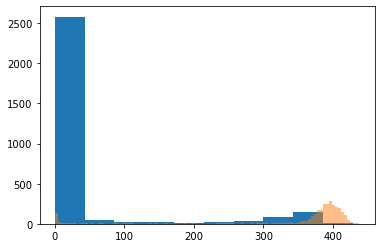

In [44]:
import matplotlib.pyplot as plt
fmnist_Gradients = torch.tensor(fmnist_Gradients)
plt.hist(fmnist_Gradients, bins=10)

mnist_Gradients = torch.tensor(mnist_Gradients)
plt.hist(mnist_Gradients, bins=100, alpha=0.5)

AUC for Gradient Norm is:  0.9660128888888888


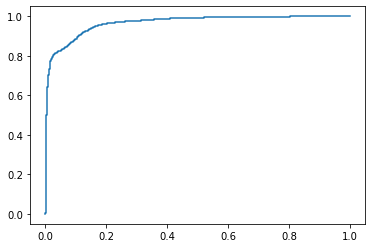

In [45]:
from sklearn import metrics

combined = np.concatenate((fmnist_Gradients, mnist_Gradients))
label_1 = np.ones(len(fmnist_Gradients))
label_2 = np.zeros(len(mnist_Gradients))
label = np.concatenate((label_1, label_2))

fpr, tpr, thresholds = metrics.roc_curve(label, combined, pos_label=0)

#plot_roc_curve(fpr, tpr)

rocauc = metrics.auc(fpr, tpr)
print('AUC for Gradient Norm is: ', rocauc)
plt.plot(fpr, tpr)